In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import pearsonr

# Basic simulation parameters

In [120]:
mu_x = -3 # log10(oral bacterial fraction)
mu_y = 8  # log10(total bacterial load)
sigma_array = [0] + [10**x for x in np.linspace(-2,0,41)] # standard deviation
n_ind = 1000 # total number of individuals
n_samples_per_ind = 5 # number of samples per individual
p_perturbed = 0.1 # number of individuals that have been perturbed
mc_runs = 10

# Simulate longitudinal data (10% receive treatment that result in oral bacterial enrichment)

In [121]:
res = []
for k in np.arange(mc_runs):
    for sigma in sigma_array:
        cov = np.array([[sigma, 0], [0, sigma]]) # covariance matrix
        baselines = np.random.multivariate_normal([mu_x, mu_y], cov, size=n_ind) # generate baseline for individuals
        df_baselines = pd.DataFrame(baselines, columns=['mu_x','mu_y'])
        df_baselines.loc[df_baselines.mu_x>0, 'mu_x'] = 0

        # generate time series for each individual
        for i in np.arange(n_ind):
            ctr_x = df_baselines.iloc[i,0]
            ctr_y = df_baselines.iloc[i,1]
            res.append([sigma, k, i, ctr_x, ctr_y, 'marker'])
            res.append([sigma, k, i, ctr_x, ctr_y, 'expansion'])
            res.append([sigma, k, i, ctr_x, ctr_y, 'average'])

            # determine if the individual received perturbations
            m = random.uniform(0, 1)
            if m <= p_perturbed:
                # perturbed, randomly sample oral fraction between mu_x and 0
                perturbed_x = np.random.uniform(low=ctr_x, high=0, size=n_samples_per_ind-1)
                df_perturbed_data = pd.DataFrame(perturbed_x, columns=['Perturbed_x'])
                
                # marker hypothesis
                df_perturbed_data['new_mu_y_marker'] = ctr_y-(df_perturbed_data['Perturbed_x']-ctr_x)
                df_perturbed_data['Perturbed_y_marker'] = np.random.normal(df_perturbed_data['new_mu_y_marker'], sigma)
                
                # expansion hypothesis
                gut_load = (1-10**ctr_x) * (10**ctr_y)
                df_perturbed_data['new_mu_y_expansion'] = np.log10(gut_load/(1-10**df_perturbed_data['Perturbed_x']))
                df_perturbed_data['Perturbed_y_expansion'] = np.random.normal(df_perturbed_data['new_mu_y_expansion'], sigma)

                # add data
                for px, py_m, py_e in zip(df_perturbed_data.Perturbed_x, df_perturbed_data.Perturbed_y_marker, df_perturbed_data.Perturbed_y_expansion):
                    res.append([sigma, k, i, px, py_m, 'marker'])
                    res.append([sigma, k, i, px, py_e, 'expansion'])
                    res.append([sigma, k, i, px, (py_m+py_e)/2, 'average'])
            else:
                # no perturbation, generate n_samples_per_ind-1 baselines
                addl_baselines = np.random.multivariate_normal([ctr_x, ctr_y], cov, size=n_samples_per_ind-1)
                df_addl_baselines = pd.DataFrame(addl_baselines, columns=['mu_x','mu_y'])
                df_addl_baselines.loc[df_addl_baselines.mu_x>0, 'mu_x'] = 0
                for addl_x, addl_y in zip(df_addl_baselines.mu_x, df_addl_baselines.mu_y):
                    res.append([sigma, k, i, addl_x, addl_y, 'marker'])
                    res.append([sigma, k, i, addl_x, addl_y, 'expansion'])
                    res.append([sigma, k, i, addl_x, addl_y, 'average'])
df_res = pd.DataFrame(res, columns=['Sigma','MC','Individual','X','Y','Hypothesis'])
df_res.to_csv("simulated_longitudinal_data_%d.csv.gz"%(n_ind), index=False, compression="gzip")

# Simulate case-control data (the same number of patients and healthy controls. all patient receive treatment that may lead to oral bacterial enrichment)

In [122]:
res = []
for k in np.arange(mc_runs):
    for sigma in sigma_array:
        cov = np.array([[sigma, 0], [0, sigma]]) # covariance matrix
        
        # create baseline samples for healthy controls
        baselines_hc = np.random.multivariate_normal([mu_x, mu_y], cov, size=int(n_ind/2))
        df_baselines_hc = pd.DataFrame(baselines_hc, columns=['mu_x','mu_y'])
        df_baselines_hc.loc[df_baselines_hc.mu_x>0, 'mu_x'] = 0
        
        # create baseline samples for patients
        baselines_pa = np.random.multivariate_normal([mu_x, mu_y], cov, size=int(n_ind/2))
        df_baselines_pa = pd.DataFrame(baselines_pa, columns=['mu_x','mu_y'])
        df_baselines_pa.loc[df_baselines_pa.mu_x>0, 'mu_x'] = 0

        # generate perturbed sample for patients
        for i in np.arange(int(n_ind/2)):
            # add data for HC
            ctr_x = df_baselines_hc.iloc[i,0]
            ctr_y = df_baselines_hc.iloc[i,1]
            res.append([sigma, k, i, ctr_x, ctr_y, 'marker'])
            res.append([sigma, k, i, ctr_x, ctr_y, 'expansion'])
            res.append([sigma, k, i, ctr_x, ctr_y, 'average'])

            # add data for patient
            ctr_x = df_baselines_pa.iloc[i,0]
            ctr_y = df_baselines_pa.iloc[i,1]
            
            # determine if the individual received perturbations
            m = random.uniform(0, 1)
            if m <= p_perturbed:
                # perturbed, randomly sample oral fraction between mu_x and 0
                perturbed_x = np.random.uniform(low=ctr_x, high=0, size=1)
                df_perturbed_data = pd.DataFrame(perturbed_x, columns=['Perturbed_x'])
                
                # marker hypothesis
                df_perturbed_data['new_mu_y_marker'] = ctr_y-(df_perturbed_data['Perturbed_x']-ctr_x)
                df_perturbed_data['Perturbed_y_marker'] = np.random.normal(df_perturbed_data['new_mu_y_marker'], sigma)
                                    
                # expansion hypothesis
                gut_load = (1-10**ctr_x) * (10**ctr_y)
                df_perturbed_data['new_mu_y_expansion'] = np.log10(gut_load/(1-10**df_perturbed_data['Perturbed_x']))
                df_perturbed_data['Perturbed_y_expansion'] = np.random.normal(df_perturbed_data['new_mu_y_expansion'], sigma)

                # add data
                res.append([sigma, k, i, df_perturbed_data.iloc[0,:].Perturbed_x, df_perturbed_data.iloc[0,:].Perturbed_y_marker, 'marker'])
                res.append([sigma, k, i, df_perturbed_data.iloc[0,:].Perturbed_x, df_perturbed_data.iloc[0,:].Perturbed_y_expansion, 'expansion'])
                res.append([sigma, k, i, df_perturbed_data.iloc[0,:].Perturbed_x, (df_perturbed_data.iloc[0,:].Perturbed_y_marker+df_perturbed_data.iloc[0,:].Perturbed_y_expansion)/2, 'average'])
            else:
                # no perturbation, generate another baseline
                addl_baselines = np.random.multivariate_normal([ctr_x, ctr_y], cov, size=1)
                df_addl_baselines = pd.DataFrame(addl_baselines, columns=['mu_x','mu_y'])
                df_addl_baselines.loc[df_addl_baselines.mu_x>0, 'mu_x'] = 0
                res.append([sigma, k, i, df_addl_baselines.iloc[0, :].mu_x, df_addl_baselines.iloc[0, :].mu_y, 'marker'])
                res.append([sigma, k, i, df_addl_baselines.iloc[0, :].mu_x, df_addl_baselines.iloc[0, :].mu_y, 'expansion'])
                res.append([sigma, k, i, df_addl_baselines.iloc[0, :].mu_x, df_addl_baselines.iloc[0, :].mu_y, 'average'])
df_res = pd.DataFrame(res, columns=['Sigma','MC','Individual','X','Y','Hypothesis'])
df_res.to_csv("simulated_case_control_data_%d.csv.gz"%(n_ind), index=False, compression="gzip")

# Plot Pearson's correlation coefficient vs. sigma

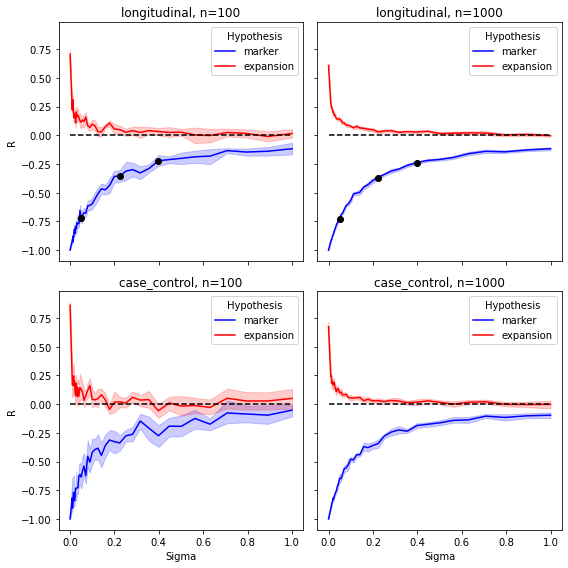

In [153]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True, sharey=True)

for k1, sim_type in enumerate(['longitudinal','case_control']):
    for k2, n_data in enumerate([100,1000]):
        
        pcc = []
        df_res = pd.read_csv('simulated_%s_data_%d.csv.gz'%(sim_type, n_data), compression="gzip")
        all_sigma = np.sort(np.array(list(set(df_res.Sigma))))
        for k in np.arange(mc_runs):
            df_res_k = df_res[df_res.MC==k]
            for h in ['marker','expansion']:
                df_res_k_h = df_res_k[df_res_k.Hypothesis==h]
                for sigma in all_sigma:
                    slope, intercept, r, p, se = linregress(df_res_k_h[df_res_k_h.Sigma==sigma].X, df_res_k_h[df_res_k_h.Sigma==sigma].Y)
                    pcc.append([k, h, sigma, slope, r, p])
        df_pcc = pd.DataFrame(pcc, columns=['MCrun','Hypothesis','Sigma','Slope','R','P'])

        _ = sns.lineplot(x="Sigma", y="R", hue='Hypothesis', data=df_pcc, ax=ax[k1,k2], palette=['blue','red'])
        _ = ax[k1,k2].plot([0,1],[0,0],'k--')
        _ = ax[k1,k2].set_title("%s, n=%d"%(sim_type, n_data))
        
        if sim_type=='longitudinal':
            for sigma in all_sigma[[15,28,33]]:
                y = np.mean(df_pcc.loc[(df_pcc.Sigma==sigma) & (df_pcc.Hypothesis=='marker'), 'R'])
                _ = ax[k1,k2].plot(sigma, y, 'ko')
        
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("synthetic_data_pearson_correlation_coefficient.svg", dpi=600, format="svg", bbox_inches="tight")

# Plot synthetic scatter plot of oral bacterial fraction vs. total bacterial load

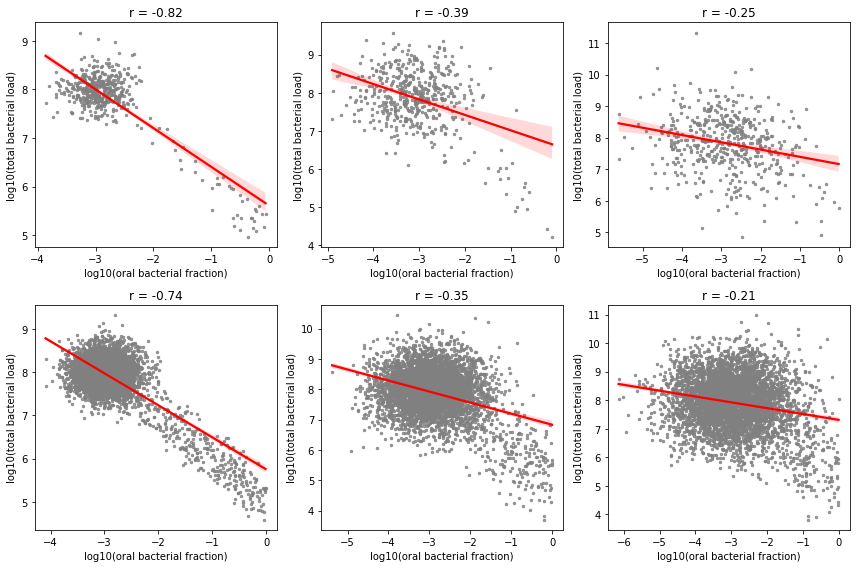

In [152]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

for k1, n_data in enumerate([100,1000]):
    df_res = pd.read_csv('simulated_longitudinal_data_%d.csv.gz'%(n_data), compression="gzip")
    all_sigma = np.sort(np.array(list(set(df_res.Sigma))))
    for k2, sigma in enumerate(all_sigma[[15,28,33]]):
        df_res_k = df_res[(df_res.MC==0) & (df_res.Hypothesis=='marker')&(df_res.Sigma==sigma)]
        _ = sns.regplot(x="X", y="Y", data=df_res_k, ax=ax[k1,k2], line_kws={"color": "red"}, scatter_kws={"color": "gray", 's':6})
        slope, intercept, r, p, se = linregress(df_res_k.X, df_res_k.Y)
        _ = ax[k1,k2].set_title("r = %2.2f"%(r))
        _ = ax[k1,k2].set_xlabel('log10(oral bacterial fraction)')
        _ = ax[k1,k2].set_ylabel('log10(total bacterial load)')
        
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("synthetic_data_bacterial_load_vs_oral_fraction.svg", dpi=600, format="svg", bbox_inches="tight")